# Examinación de información disponible referente a reseñas de productos
Se tomará el repositorio de datos público de reseñas de productos de Amazon Reviews. Se trata de un conjunto de información recopilada en el 2020 referente a productos de diversas categorías. Actualmente se plantea el estudio de únicamente los productos pertenecientes al entorno tecnológico.

Específicamente, se eligieron las siguientes categorías:
- Accesorios y Celulares
- Electrónica
- Software
- Videojuegos

## Importación de librerias necesarias

In [1]:
import pyspark.sql.functions as F
from pyspark.sql import SQLContext, SparkSession, types as T, DataFrame
import requests
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import BinaryType
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

from matplotlib.ticker import FuncFormatter

import tensorflow_hub as hub

import os
import dotenv
import re
import html

from delta import configure_spark_with_delta_pip

from pyspark.ml.functions import predict_batch_udf

2025-06-07 22:34:49.619799: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 22:34:49.959518: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 22:34:50.272289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749353690.498655  385072 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749353690.566695  385072 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-07 22:34:51.184150: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
print(os.popen("java -version 2>&1").read())

openjdk version "17.0.15" 2025-04-15
OpenJDK Runtime Environment (build 17.0.15+6-Ubuntu-0ubuntu124.04)
OpenJDK 64-Bit Server VM (build 17.0.15+6-Ubuntu-0ubuntu124.04, mixed mode, sharing)



In [3]:
REGENERATE_INTERMEDIATE = True

In [4]:
BASE_JSON_PATH = os.getenv("BASE_JSON_PATH")

In [5]:
metastore_schema_path = "/mnt/c/Users/User/Documents/Maestría/Amazon Reviews Code/data"

In [6]:
builder = (
    SparkSession.builder \
        .appName("LocalUnityCatalog") \
        .config("spark.jars.packages", "io.delta:delta-spark_2.12:3.2.1,mysql:mysql-connector-java:8.0.33") \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
        .config("spark.sql.warehouse.dir", f"{metastore_schema_path}/.warehouse") \
        .config("javax.jdo.option.ConnectionURL", f"jdbc:derby:{metastore_schema_path}/metastore_db;create=true") \
        .master("local[2]") \
        .enableHiveSupport()
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

your 131072x1 screen size is bogus. expect trouble
25/06/07 22:36:26 WARN Utils: Your hostname, ASUSPRIMEA520MAII resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/06/07 22:36:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/mnt/c/Users/User/Documents/Maestr%c3%ada/Amazon%20Reviews%20Code/.venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/edgar/.ivy2/cache
The jars for the packages stored in: /home/edgar/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-cd924c84-2c91-441b-9d09-a44c6235167e;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.3.1 in central
	found io.delta#delta-storage;3.3.1 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 222ms :: artifacts dl 8ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.3.1 from central in [default]
	io.delta#delta-storage;3.3.1 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0   

In [7]:
spark.sparkContext.setLogLevel("ERROR")

Inicializar esquemas destino

In [8]:
spark.sql("CREATE SCHEMA IF NOT EXISTS spark_catalog.product_reviews_schema")

DataFrame[]

## Importar información de caracterización de productos
Se carga información de productos, incluyendo características abstraídas en su descripción, categoría principal, cantidad de referencias, calificación promedio, precio y código interno (parent_asin). Este último código refleja la categoría general del producto, descartando características particulares como color o presentación, lo cuál no se considerará dentro del estudio.

In [9]:
item_schema = T.StructType([
    T.StructField("title", T.StringType(), True),
    T.StructField("main_category", T.StringType(), True),
    T.StructField("features", T.ArrayType( T.StringType() ), True),
    T.StructField("description", T.ArrayType( T.StringType() ), True),
    T.StructField("average_rating", T.FloatType(), True),
    T.StructField("rating_number", T.IntegerType(), True),
    T.StructField("price", T.DoubleType(), True),
    T.StructField("store", T.StringType(), True),
    T.StructField("parent_asin", T.StringType(), True),
    T.StructField("categories", T.ArrayType(T.StringType()), True),
    T.StructField("details", T.StringType(), True),
    T.StructField("images", T.ArrayType(T.StringType()), True),
])

#### Se consideran 4 categorìas: Software, Electrònica, Celulares & Accesorios y Videojuegos.

In [10]:
def load_category_data( path ) -> DataFrame:
    file = (
        spark.read
            .format('json')
            .option("quote",'/"')
            .schema(item_schema)
            .load(path)
        )

    return file

In [11]:
def merge_dfs( *args ):
    base = args[0]
    for i in range(1, len(args)):
        base = base.unionByName( base )

    return base

In [12]:
if REGENERATE_INTERMEDIATE:

    meta_software = load_category_data( f"{BASE_JSON_PATH}/meta_categories/meta_Software.jsonl" )
    meta_electronics = load_category_data( f"{BASE_JSON_PATH}/meta_categories/meta_Electronics.jsonl" )
    meta_Cell_Phones_and_Accessories = load_category_data( f"{BASE_JSON_PATH}/meta_categories/meta_Cell_Phones_and_Accessories.jsonl" )
    meta_Video_Games = load_category_data( f"{BASE_JSON_PATH}/meta_categories/meta_Video_Games.jsonl" )

    unified_meta_items = merge_dfs(
        meta_software, meta_electronics,
        meta_Cell_Phones_and_Accessories, meta_Video_Games
    )

    (
        unified_meta_items.write
            .format('delta')
            .mode('overwrite')
            .saveAsTable('spark_catalog.product_reviews_schema.meta_items')
    )

unified_meta_items = spark.table('spark_catalog.product_reviews_schema.meta_items')

##### Cantidad de productos totales distintos

In [13]:
unified_meta_items.count()

714008

Se revisa la cantidad de productos padres distintos, es decir, productos reales descartando variantes como color y presentaciòn

In [14]:
unified_meta_items[['parent_asin']].distinct().count()

89251

#### Revisión general de productos y atributos

In [15]:
unified_meta_items.limit(20).toPandas()

,title,main_category,features,description,average_rating,rating_number,price,store,parent_asin,categories,details,images
0,Accupressure Guide,Appstore for Android,[All the pressing point has been explained wit...,[Acupressure technique is very ancient and ver...,3.6,NaN,0.00,mAppsguru,B00VRPSGEO,[],"{""Release Date"":""2015"",""Date first listed on A...","[{""large"":""https://m.media-amazon.com/images/I..."
1,Ankylosaurus Fights Back - Smithsonian's Prehi...,Appstore for Android,[ENCOURAGE literacy skills with highlighted na...,[Join Ankylosaurus in this interactive book ap...,4.0,NaN,2.99,"Oceanhouse Media, Inc",B00NWQXXHQ,[],"{""Release Date"":""2014"",""Date first listed on A...","[{""large"":""https://m.media-amazon.com/images/I..."
2,Mahjong 2015,Appstore for Android,[Mahjong 2015 is a free solitaire matching gam...,[Mahjong 2015 is a free solitaire matching gam...,3.1,NaN,0.00,sophiathach,B00RFKP6AC,[],"{""Release Date"":""2014"",""Date first listed on A...","[{""large"":""https://m.media-amazon.com/images/I..."
3,Jewels Brick Breakout,Appstore for Android,"[Game Features:, - Intuitive touch controls wi...",[Jewels Brick Breakout is a glowing jewels bri...,4.2,NaN,0.00,Bad Chicken,B00SP2QU0E,[],"{""Release Date"":""2015"",""Date first listed on A...","[{""large"":""https://m.media-amazon.com/images/I..."
4,Traffic Police: Off-Road Cub,Appstore for Android,"[In this game you will find:, - Killer police ...",[Become the best road police officer in Cube C...,3.3,NaN,0.00,Dast 2 For Metro,B01DZIT64O,[],"{""Release Date"":""2016"",""Date first listed on A...","[{""large"":""https://m.media-amazon.com/images/I..."
5,Shadow Fighting Superhero War,Appstore for Android,"[Shadow combat super battle, Addicting gamepla...","[Let’s start to use different approach, dodge ...",3.3,NaN,0.00,3D Futuristic Games,B07F89XZF3,[],"{""Release Date"":""2018"",""Date first listed on A...","[{""large"":""https://m.media-amazon.com/images/I..."
6,My Aquarium - Hidden Object Challenge # 122,Appstore for Android,[100 Levels full of seek and find hidden objec...,[Did you search games for Hidden Object Games ...,3.0,NaN,0.00,PlayHOG,B00PY3WIEE,[],"{""Release Date"":""2014"",""Date first listed on A...","[{""large"":""https://m.media-amazon.com/images/I..."
7,Giant Surprise Petcage! Unlock Superhero Puppy,Appstore for Android,"[Latest surprise kit with pet goals., Include ...",[Love surprise opening and unboxing cute littl...,2.9,NaN,0.00,Surprise Unboxing Games,B08DNZVD7Q,[],"{""Release Date"":""2020"",""Date first listed on A...","[{""large"":""https://m.media-amazon.com/images/I..."
8,Ac Market tips,Appstore for Android,[We personally check and use the apps and play...,[Application made by fans for fans!Complete an...,3.3,NaN,0.00,Azeed,B076J3SJ4G,[],"{""Release Date"":""2017"",""Date first listed on A...","[{""large"":""https://m.media-amazon.com/images/I..."
9,Gem Shopping Network,Appstore for Android,"[Live Stream!, Call to shop, ask questions, an...",[Watch Gem Shopping Network Live!],3.8,816.0,0.00,Gem Shopping Network Inc.,B01GUEBBC0,[],"{""Release Date"":""2016"",""Date first listed on A...","[{""large"":""https://m.media-amazon.com/images/I..."


Cantidad promedio de caracteres en descripciones

In [16]:
mean_description_chars = (
    unified_meta_items
        .select( F.length( F.col('description')[0] ).alias('len') )
        .agg( F.avg( F.col('len') ).alias('mean_len') )
        .collect()
)[0]['mean_len']

print(f'Cantidad media de caracteres en descripciones: {mean_description_chars}')

Cantidad media de caracteres en descripciones: 901.2643493174824


Categorías disponibles

In [17]:
(
    unified_meta_items
        .select( F.col('main_category') )
        .distinct()
).toPandas()

,main_category
0,Computers
1,Home Audio & Theater
2,Software
3,Appstore for Android
4,Gift Cards
5,Toys & Games
6,Books
7,AMAZON FASHION
8,None


## Importar información de referencias de usuarios del producto
Se carga información de opiniones de usuarios sobre diferentes productos. Los productos se califican en un rango de 1 a 5, incluyendo un título y texto, así mismo, se incluye información de imágenes, código de la variante del producto, código padre del producto (descartando variantes como color, presentación, etc), identificador de usuario, hora de la revisión, y calificación de la referencia (helpful).

In [18]:
review_schema = T.StructType([
    T.StructField("rating", T.FloatType(), True),
    T.StructField("title", T.StringType(), True),
    T.StructField("text", T.StringType(), True),
    T.StructField("timestamp", T.StringType(), True),
    T.StructField("helpful_vote", T.IntegerType(), True),
    T.StructField("parent_asin", T.StringType(), True),
    T.StructField("images", T.ArrayType(T.StringType()), True),
])

In [19]:
def load_review_data( path ) -> DataFrame:
    file = (
        spark.read
            .format('json')
            .option("quote",'/"')
            .schema(review_schema)
            .load(path)
        )

    return file

In [20]:
if REGENERATE_INTERMEDIATE:

    software = load_review_data( f"{BASE_JSON_PATH}/review_categories/Software.jsonl" )
    electronics = load_review_data( f"{BASE_JSON_PATH}/review_categories/Electronics.jsonl" )
    cell_Phones_and_Accessories = load_review_data( f"{BASE_JSON_PATH}/review_categories/Cell_Phones_and_Accessories.jsonl" )
    video_Games = load_review_data( f"{BASE_JSON_PATH}/review_categories/Video_Games.jsonl" )

    unified_reviews = (
        software.unionByName(
            electronics.unionByName(
                cell_Phones_and_Accessories.unionByName(
                    video_Games
                )
            )
        )
    )

    (
        unified_reviews.write
            .format('delta')
            .mode('overwrite')
            .saveAsTable('spark_catalog.product_reviews_schema.reviews')
    )

unified_reviews = spark.table('spark_catalog.product_reviews_schema.reviews')

In [21]:
unified_reviews.limit(20).toPandas()

,rating,title,text,timestamp,helpful_vote,parent_asin,images
0,5.0,Better quality than Apple cable!,This cable is extremely heavy duty. Compared t...,1383744029000,0,B07YQFC61B,[]
1,3.0,Slow beyond belief,I like the size of this thumb drive. I got it ...,1351139436000,1,B00JO6RO8C,[]
2,5.0,"Flawless implementation, looked good enough to...",This caddy was amazing. Had the identical form...,1346112480000,0,B0058AH2US,[]
3,5.0,Free Electricity!,I grew tired of taking down my security camera...,1678624877223,0,B09T61BPBX,[]
4,3.0,Not Happy I Bought It,I was looking for a cheap little amp to play m...,1661629517483,0,B07W46QV5J,[]
5,5.0,Exact Replacement,"We had a power failure recently and, unbeknown...",1613835840081,2,B09TGJGSQD,[]
6,5.0,Quality That Exceeds The Price,I bought a pair of these for my daughter after...,1613834315700,0,B08XPWDSWW,[]
7,5.0,Work From Home Gem,I have been using a 9-year-old laptop for work...,1599750698608,4,B08B3ZNPYZ,[]
8,5.0,Truly Plug and Play (HDMI) - UPDATED,UPDATE 2021-02-20<br />When my daughter's work...,1592223354271,0,B0B2K24RQT,[]
9,5.0,Surprisingly Good,"As I was playing with this unit, I kept saying...",1580476543764,13,B0C68QBKCS,[]


In [22]:
unified_reviews.count()

74204685

## Limpieza de textos
Algunos elementos de referencias de productos poseen carácteres derivados de HTML y carácteres especiales. Al tratarse de una representación semántica, se requiere de la transformación de dichos textos

In [23]:
def clean_text(text):
    if text is None:
        return None
    text = html.unescape(text)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [24]:
clean_text_udf = udf(clean_text, StringType())

In [25]:
if REGENERATE_INTERMEDIATE:

    unified_reviews_clean = (
        unified_reviews.withColumn(
            'text', clean_text_udf( F.col('text') )
        )
    )

    (
        unified_reviews.write
            .format('delta')
            .mode('overwrite')
            .saveAsTable('spark_catalog.product_reviews_schema.reviews_clean')
    )

unified_reviews_clean = spark.table('spark_catalog.product_reviews_schema.reviews_clean')

## Visualización de atributos del conjunto de datos


In [26]:
def plot_histogram( df, column, num_bins, title, categorical = False ):

    plt.figure(figsize=(10, 6))

    if not categorical:
        min_val, max_val = df.agg(F.min(column), F.max(column)).first()
        bin_width = (max_val - min_val) / num_bins

        binned_df = df.withColumn("bin", ((F.col(column) - min_val) / bin_width).cast("int"))
        histogram_df = binned_df.groupBy("bin").count().orderBy("bin")
        pdf = histogram_df.toPandas()

        pdf["bin_center"] = min_val + (pdf["bin"] + 0.5) * bin_width

        plt.figure(figsize=(10, 6))
        plt.bar(pdf["bin_center"], pdf["count"], width=bin_width * 0.9, color='skyblue', edgecolor='black')
        plt.xlabel("Valor")
        plt.ylabel("Cantidad")
        plt.title(title)

        formatter = FuncFormatter(lambda x, pos: f'{int(x):,}')
        plt.gca().xaxis.set_major_formatter(formatter)
        plt.gca().yaxis.set_major_formatter(formatter)

    else:
        agg_df = df.groupBy(column).count().orderBy("count", ascending=False).limit(20)
        pdf = agg_df.toPandas()
        categories = pdf[column]
        counts = pdf['count']
        bars = plt.bar(categories, counts, color='skyblue')

        for bar, count in zip(bars, counts):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{count:,}',
                     ha='center', va='bottom', fontsize=9)

        plt.xlabel("Valor")
        plt.ylabel("Cantidad")
        plt.title(title)
    plt.show()

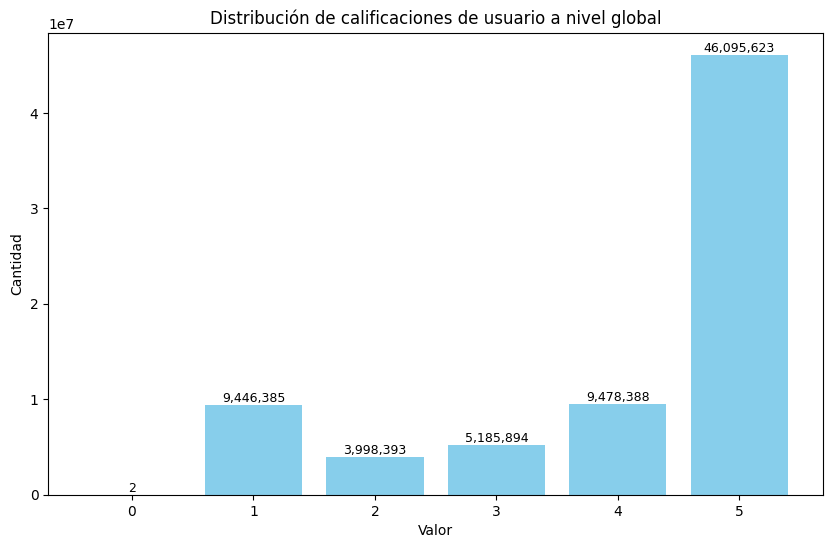

In [27]:
plot_histogram(
    unified_reviews_clean, 'rating', 20,
    'Distribución de calificaciones de usuario a nivel global',
    True
)

## Representación semántica de referencias de productos
La mayor parte del conjunto de datos original se conforma de las reseñas de usuarios de los productos publicados en Amazon. Cada una de estas referencias aporta valor describiendo la satisfacción de los usuarios con respecto al producto usado. En este sentido, vale la pena examinar algunas caracterizaciones preliminares a través de modelos pre-entrenados que permitan representar dichos textos en un formato interpretable por modleos posteriores.

In [28]:
# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder?hl=es-419
MODULE_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load( MODULE_URL )

2025-06-07 23:00:11.312363: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Se usará el modelo Universal Sentence Encoder para generar la representación numérica de las descripciones proveídas por usuarios

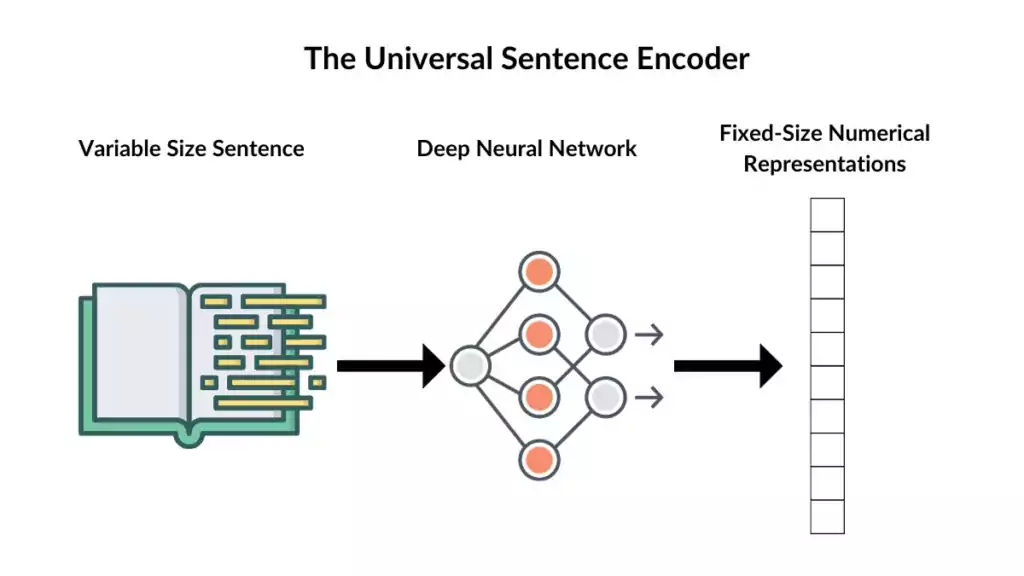

In [29]:
unified_reviews_with_phrases = (
    unified_reviews_clean
        .withColumn(
            'sentence',
            F.explode( F.split(F.col("text"), "\\.") )
        )
)

In [30]:
pandas_sample = (
    unified_reviews_with_phrases
        .filter(
            F.col('sentence').isNotNull() &
            (F.length( F.col('sentence') ) > 0 )
        )
        .limit(100000)
        .toPandas()
)

In [31]:
sentences = pandas_sample['sentence'].to_numpy()

In [32]:
embeddings = model( sentences )
embeddings.shape

2025-06-07 23:00:26.364759: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 816000000 exceeds 10% of free system memory.
2025-06-07 23:00:33.026916: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 816000000 exceeds 10% of free system memory.
2025-06-07 23:00:34.640653: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3484482560 exceeds 10% of free system memory.


TensorShape([100000, 512])

In [33]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings.numpy())
f'Varianza explicada: {pca.explained_variance_ratio_.sum() * 100} %'

'Varianza explicada: 9.489971160888672 %'

In [34]:
def sample_and_plot( ax, embedded_2d, words ):
  random_indexes = np.random.choice(embedded_2d.shape[0], size=20, replace=False)
  sampled_labels = [words[i] for i in random_indexes]
  sampled_embedded_2d = embedded_2d[random_indexes]

  ax.scatter(sampled_embedded_2d[:, 0], sampled_embedded_2d[:, 1], color='skyblue')

  for i, _ in enumerate(sampled_labels):
      index = random_indexes[ i ]
      ax.annotate(f'{index}', (sampled_embedded_2d[i, 0], sampled_embedded_2d[i, 1]))

  ax.set_title('Representación de algunas opiniones codificadas mediante modelo pre-entrenado')
  ax.set_xlabel('Comp 1')
  ax.set_ylabel('Comp 2')

  return random_indexes

/tmp/ipykernel_385072/1562355271.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


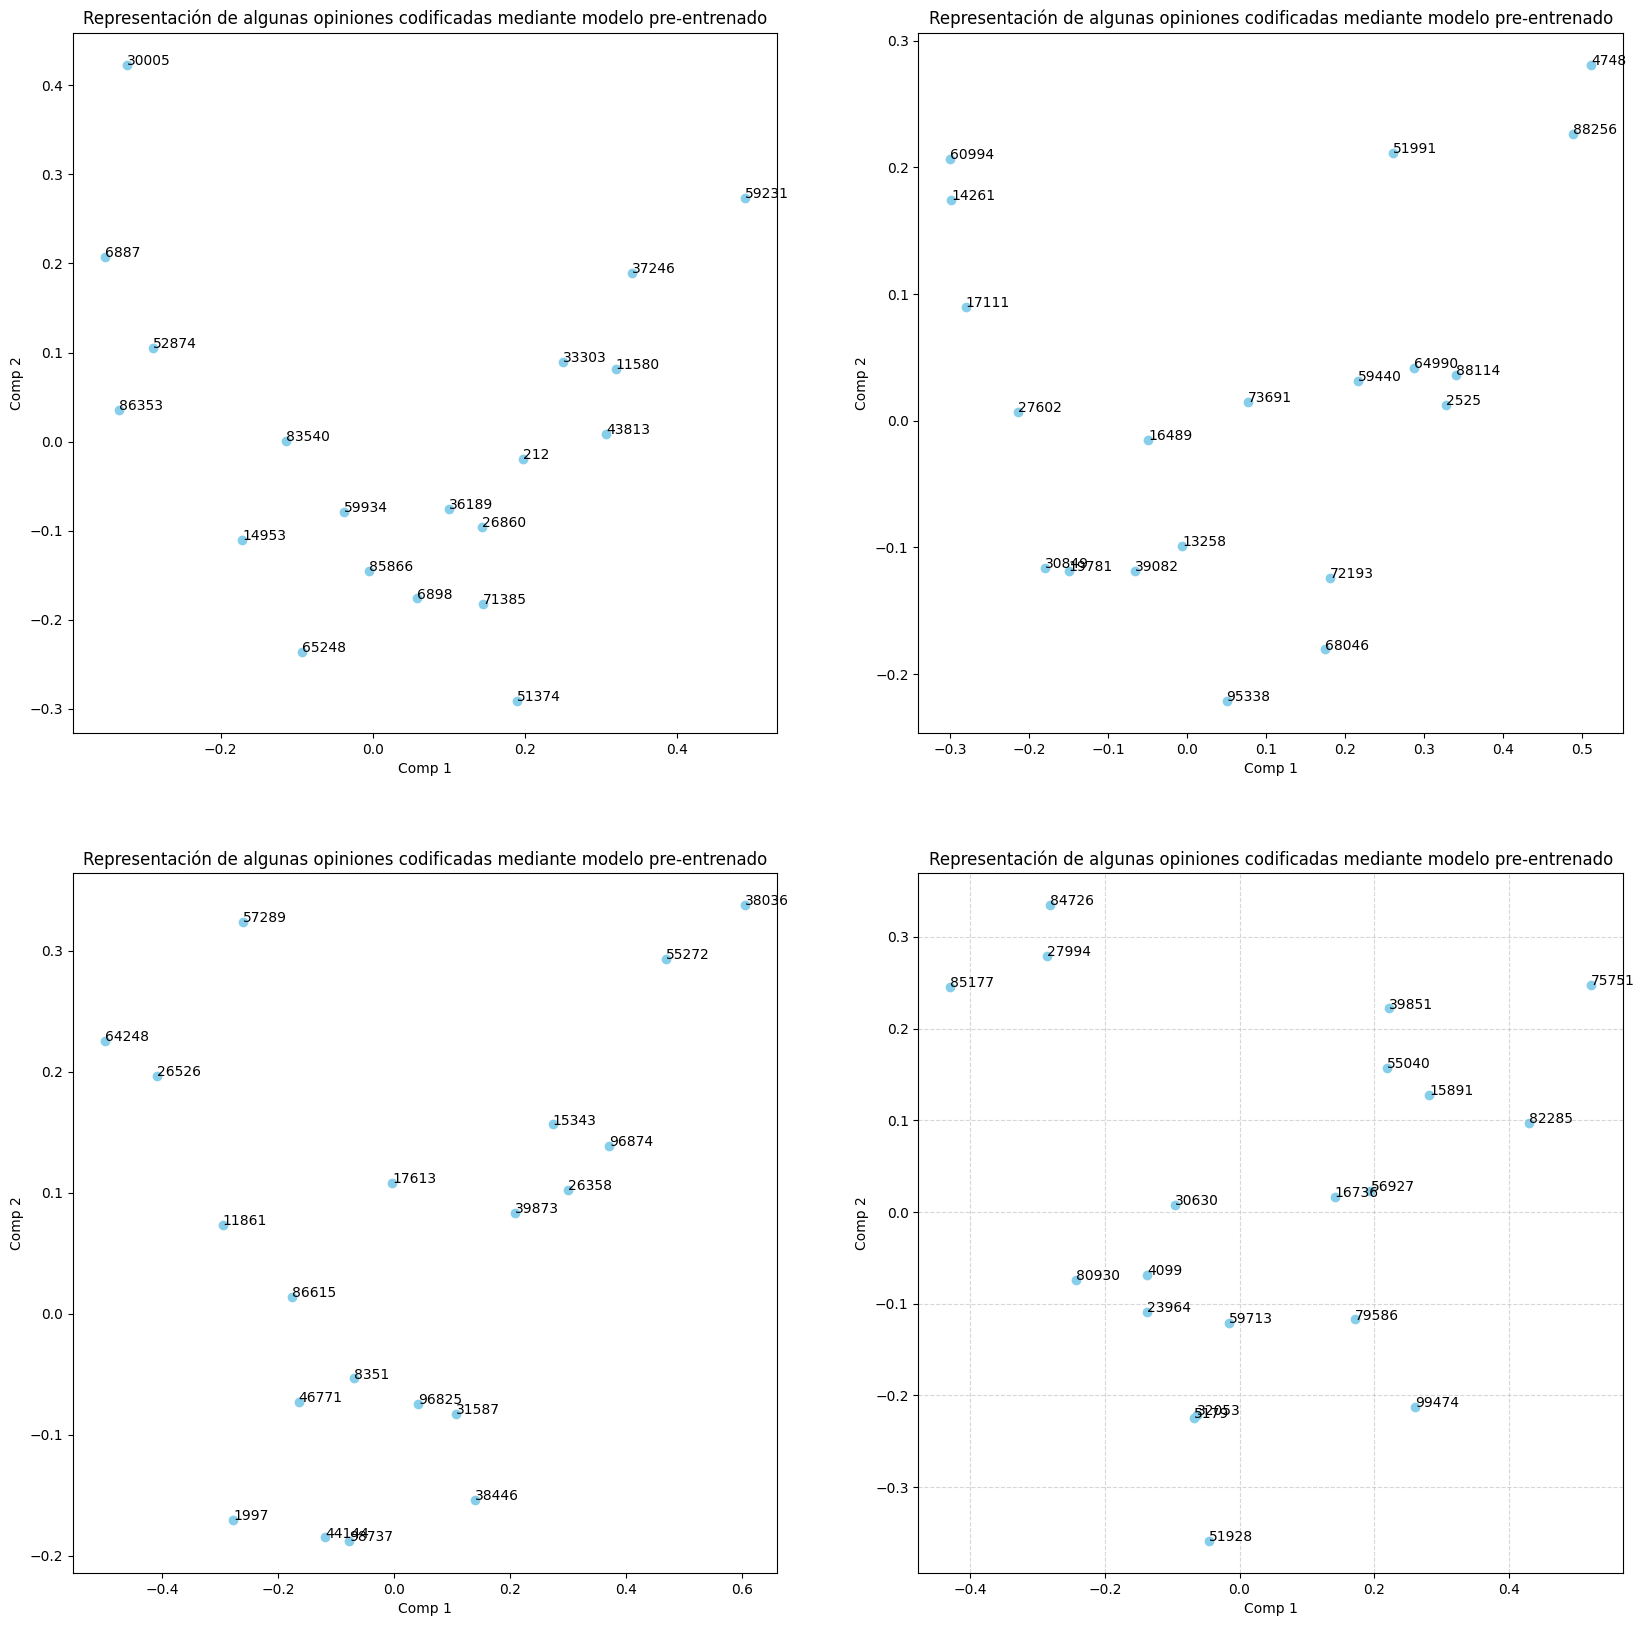

In [35]:
fig, axes = plt.subplots(2,2,figsize=(20, 20))
axes = axes.flatten()

indexes = []

for ax in axes:
    indexes.extend( sample_and_plot( ax, embeddings_2d, sentences ) )

plt.grid(True, linestyle='--', alpha=0.5)
fig.show()

In [36]:
indexes = list(set(indexes))

In [37]:
for id in sorted(indexes):
    print(f'ID: {id} Descripcion: {sentences[id]}')

ID: 212 Descripcion: Buen diseño y utilidad
ID: 1997 Descripcion:   Dropped the phone twice
ID: 2525 Descripcion:  It’s worth buying!
ID: 4099 Descripcion:  I use the Qualcomm QC 3
ID: 4748 Descripcion: love it
ID: 5179 Descripcion: I bought this a couple of weeks ago, I couldn’t return it because i think I passed the time to return it when I used it, it worked for a couple of days and then out of nowhere it’s not working
ID: 6887 Descripcion:  Second, they do not make this case for my new LG G4, and I was forced to settle for an ugly Spigen
ID: 6898 Descripcion:  My Dollar Tree one works way better
ID: 8351 Descripcion:  It is very nice that the cap screws on the other end while you use it, so you don't lose it
ID: 11580 Descripcion:  Fit properly
ID: 11861 Descripcion:  But there is no grip to this case which causes me to drop my phone and I’d rather prevent from dropping with some added grip
ID: 13258 Descripcion:  Imagine an old playing deck lf cards
ID: 14261 Descripcion: I was im

## Inclusión de imágenes y ejemplos para algunos registros

Se realiza una revisión sobre la estructuración de imágenes y sus correspondientes descripciones asociadas al producto

In [38]:
import json
from PIL import Image
import io
import numpy as np

def fetch_image_bytes(data):
    result = []

    img_data = json.loads(data.image)

    variant = img_data.get('variant')

    for k, v in img_data.items():

        if k == 'variant': continue

        img = None
        try:
            response = requests.get(v, timeout=5)
            if response.status_code == 200:
                bimg = response.content

        except Exception as e:
            bimg = None

        result.append(
            (k, variant, v, bimg)
        )

    return result


fetch_image_bytes_udf = F.udf(fetch_image_bytes, T.ArrayType(
    T.StructType([
        T.StructField('type', T.StringType()),
        T.StructField('variant', T.StringType()),
        T.StructField('url', T.StringType()),
        T.StructField('data', T.BinaryType()),
    ])
))

In [39]:
items_images = (
    unified_meta_items
        .select(
            F.col('parent_asin'),
            F.explode( F.col('images') ).alias('image')
        )
        .withColumn(
            'bytes_images', fetch_image_bytes_udf(F.struct(
                F.col('parent_asin'),
                F.col('image')
            ))
        )
        .select(
            F.col('parent_asin'),
            F.explode( F.col('bytes_images') ).alias('bytes_image')
        )
        .select(
            F.col('parent_asin'),
            F.col('bytes_image.type').alias('type'),
            F.col('bytes_image.variant').alias('variant'),
            F.col('bytes_image.url').alias('url'),
            F.col('bytes_image.data').alias('data'),
        )
)

In [40]:
if REGENERATE_INTERMEDIATE:
    (
        items_images.limit(10).write
            .format('delta')
            .mode('overwrite')
            .saveAsTable('spark_catalog.product_reviews_schema.items_images')
    )

In [41]:
df_items_images = spark.table('spark_catalog.product_reviews_schema.items_images')

In [42]:
sample_data = df_items_images.limit(10).toPandas()

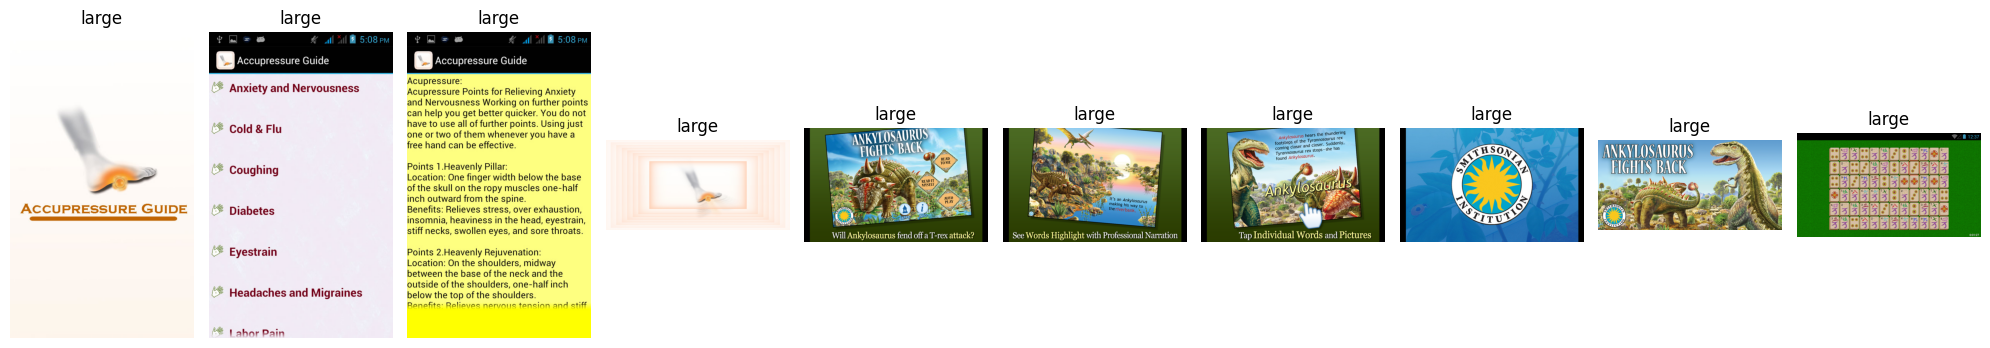

In [43]:
fig, axes = plt.subplots( 1, 10, figsize = (20,20) )
f_axes = axes.flatten()

for i, (label, img_bytes) in enumerate(zip(sample_data['type'], sample_data['data'])):
    if isinstance(img_bytes, str):
        img_bytes = eval(img_bytes)

    img = Image.open(io.BytesIO(img_bytes))
    f_axes[i].imshow(img)
    f_axes[i].set_title(str(label))
    f_axes[i].axis('off')

for j in range(i + 1, 9):
    f_axes[j].axis('off')

plt.tight_layout()
plt.show()